In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score,jaccard_score,f1_score,log_loss,classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
dest = '/content/drive/MyDrive/Python/Chicago-Crime/'
BaseDat = pd.read_csv(dest + 'Chicago_Crime_Final_Data.csv')

In [ ]:
#- i will keep only the 10 most frequent types of crime for prediction -#
KeepList = ['BATTERY','THEFT','CRIMINAL DAMAGE','ASSAULT','DECEPTIVE PRACTICE',
            'OTHER OFFENSE','MOTOR VEHICLE THEFT','WEAPONS VIOLATION','ROBBERY','BURGLARY']
BaseDat = BaseDat[BaseDat['primary_type'].isin(KeepList)]
BaseDat['Location_Desc'] = BaseDat.location_description.astype("category").cat.codes
BaseDat['Type'] = BaseDat.primary_type.astype("category").cat.codes
#- this datframe will hold the classes description -#
TypesCodes = pd.DataFrame(BaseDat.groupby('primary_type')['Type'].max())
BaseDat = BaseDat.drop(columns=['primary_type','location_description','Date'])
BaseDat.head(3)        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,beat,ward,Hour,HubDist,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WSF2,WT01,WT02,WT03,WT04,WT06,WT08,WT09,DayOfWeek,Month,Dholiday,Location_Desc,Type
0,411,8.0,6,2.501112,8.625000,0.0,0.0,46.000000,4.000000,170.0,85.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,0.0,91,7
1,1613,41.0,12,4.484144,0.625000,0.0,136.0,-30.666667,-108.666667,330.0,62.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,0.0,79,4
2,1613,45.0,9,2.305444,49.142857,72.5,365.2,7.666667,-40.333333,180.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0.0,79,4


In [ ]:
Weights = np.array(BaseDat['Type'].value_counts(normalize=True,sort=False))
Tens_Weights = torch.from_numpy(Weights).type(torch.FloatTensor)
# print(Weights)
# print(Tens_Weights)
weighted_sampler = WeightedRandomSampler(weights=Tens_Weights,num_samples=len(Tens_Weights),replacement=True)

In [ ]:
print(Weights)

[0.1089466  0.21626549 0.03465332 0.1328387  0.081454   0.05529578
 0.07371236 0.04117562 0.20718373 0.04847439]


## Deep Neural Network (DNN) with PyTorch

### Standartization and spliting

In [ ]:
y = BaseDat.loc[:, BaseDat.columns == 'Type']
X = BaseDat.drop(['Type'],axis=1)
#- convert to arrays -#
X = np.asarray(X)
y = np.asarray(y)
#- standardizing the features and spliting for train/test -#
X = preprocessing.MinMaxScaler().fit(X).transform(X)
print(X.shape)
#- split -#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(173865, 22)
(139092, 22) (34773, 22) (139092, 1) (34773, 1)


In [ ]:
class Data():
    # Constructor
    def __init__(self, x_tensor, y_tensor):
        self.y = y_tensor 
        self.x = x_tensor 
    # Getter    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    # Get Length   
    def __len__ (self):
        return len(self.x)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

In [ ]:
# Define The accuracy function
def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

In [ ]:
# Define the training function of the model
def train(data_set, model, criterion, train_loader, optimizer, epochs=200):
    LOSS = []
    for epoch in range(epochs):
        print('Epoch num:', epoch)
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, torch.max(y, 1)[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            LOSS.append(loss.item())
        print('Loss:', loss.item())

In [ ]:
#- prepare the tensors for input
x_train_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.LongTensor)
data_set = Data(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=data_set, batch_size=1000, sampler=weighted_sampler)

In [ ]:
# set the parameters (1 hidden layer with 100 neurons)
input_size = 22
hidden_size = 100
num_classes = 10
model = NeuralNet(input_size, hidden_size, num_classes)
learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Train he model
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs=200)

Epoch num: 0
Loss: 2.444218397140503
Epoch num: 1
Loss: 2.4370808601379395
Epoch num: 2
Loss: 2.443902015686035
Epoch num: 3
Loss: 2.4324991703033447
Epoch num: 4
Loss: 2.4477972984313965
Epoch num: 5
Loss: 2.4380135536193848
Epoch num: 6
Loss: 2.444397449493408
Epoch num: 7
Loss: 2.4283223152160645
Epoch num: 8
Loss: 2.4427194595336914
Epoch num: 9
Loss: 2.4451422691345215
Epoch num: 10
Loss: 2.4172425270080566
Epoch num: 11
Loss: 2.426570415496826
Epoch num: 12
Loss: 2.4540867805480957
Epoch num: 13
Loss: 2.4458518028259277
Epoch num: 14
Loss: 2.4431052207946777
Epoch num: 15
Loss: 2.4279706478118896
Epoch num: 16
Loss: 2.428091526031494
Epoch num: 17
Loss: 2.428128719329834
Epoch num: 18
Loss: 2.4255685806274414
Epoch num: 19
Loss: 2.4421610832214355
Epoch num: 20
Loss: 2.4223504066467285
Epoch num: 21
Loss: 2.432729959487915
Epoch num: 22
Loss: 2.4457345008850098
Epoch num: 23
Loss: 2.421910047531128
Epoch num: 24
Loss: 2.420130729675293
Epoch num: 25
Loss: 2.4154131412506104
Epoch

## Accuracy on test Data

In [ ]:
x_test_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.LongTensor)
predicted = model(x_test_tensor)
_, predicted_Class = torch.max(predicted, dim=1)

In [ ]:
# print(y_test_tensor[:2])
# print(predicted[:2])
# print(predicted_Class[:2])

Accuracy of DL Model: 0.13460645587575587
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3788
           1       0.23      0.04      0.07      7520
           2       0.00      0.00      0.00      1205
           3       0.13      0.94      0.23      4619
           4       0.16      0.05      0.08      2833
           5       0.00      0.00      0.00      1923
           6       0.00      0.00      0.00      2563
           7       0.00      0.00      0.00      1432
           8       0.00      0.00      0.00      7204
           9       0.00      0.00      0.00      1686

    accuracy                           0.14     34773
   macro avg       0.05      0.10      0.04     34773
weighted avg       0.08      0.14      0.05     34773



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


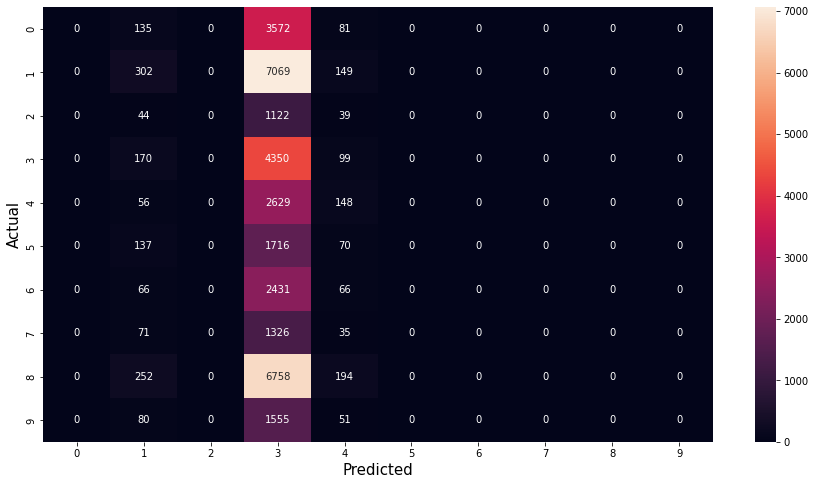

In [ ]:
data_set = Data(x_test_tensor, y_test_tensor)
Accu = accuracy(model, data_set)
print('Accuracy of DL Model:', Accu)
print(classification_report(y_test, predicted_Class))
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(confusion_matrix(y_test, predicted_Class), annot=True, fmt="d")
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.show()